<a href="https://colab.research.google.com/github/podo47/DL_HW2_Handcraft_LeNet5-Computational_Graph/blob/main/DL_HW2_Lenet5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LeNet-5

## Mount to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import libraries

In [ ]:
import os
import math
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image
import cv2
from multiprocessing.pool import ThreadPool
import time
import pickle
from tqdm import tqdm

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## Part 1 : Data preprocessing

### Import data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/images/train.txt', sep=" ",header=None)
train_dir = np.array(train[0])
train_y = np.array(train[1])

valid = pd.read_csv('/content/drive/MyDrive/images/val.txt', sep=" ",header=None)
valid_dir = np.array(valid[0])
valid_y = np.array(valid[1])

test = pd.read_csv('/content/drive/MyDrive/images/test.txt', sep=" ",header=None)
test_dir = np.array(test[0])
test_y = np.array(test[1])

### Read images to array

In [ ]:
def read_image(imgname):
    img = cv2.imread('/content/drive/MyDrive/'+imgname)
    img = cv2.resize(img, (28, 28))
    return img

def read_images_to_array(data_dir):
    pool = ThreadPool(processes=2) # 指定使用 2 個進程
    X = pool.map(read_image, data_dir)
    pool.close()
    pool.join()
    X = np.array(X)
    return X

#### Save data (can skip)

In [ ]:
# To save time, you can just skip this step, as the output has already been stored

X_train = read_images_to_array(train_dir)
X_valid = read_images_to_array(valid_dir)
X_test = read_images_to_array(test_dir)


In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/images/rgb_dataset.npz", traindata=X_train, validdata=X_valid, testdata=X_test)

#### Load data

In [ ]:
# To save time, you can just skip this step, as the output has already been stored

with np.load("/content/drive/MyDrive/images/rgb_dataset.npz") as data:
    X_train = data["traindata"]
    X_valid = data["validdata"]
    X_test = data["testdata"]


In [ ]:
print('X_train shape : ', X_train.shape)
print('X_valid shape : ',X_valid.shape)
print('X_test shape : ',X_test.shape)

X_train shape :  (63325, 28, 28, 3)
X_valid shape :  (450, 28, 28, 3)
X_test shape :  (450, 28, 28, 3)


### Mini-batch

In [ ]:
# generate random-shuffled mini-batches
def random_mini_batches(image, label, mini_batch_size = 256):
    dataset_size = image.shape[0] # number of training examples
    mini_batches = []
    # shuffle (image, label)
    permutation = list(np.random.permutation(dataset_size))
    shuffled_image = image[permutation, :, :, :]
    shuffled_label = label[permutation]
    # partition (shuffled_image, shuffled_label). Minus the end case.
    complete_minibatches_number = math.floor(dataset_size / mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, complete_minibatches_number):
        mini_batch_image = shuffled_image[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :, :, :]
        mini_batch_label = shuffled_label[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_image, mini_batch_label)
        mini_batches.append(mini_batch)
    # handle the end case (last mini-batch < mini_batch_size)
    if dataset_size % mini_batch_size != 0:
        mini_batch_image = shuffled_image[complete_minibatches_number * mini_batch_size: dataset_size, :, :, :]
        mini_batch_label = shuffled_label[complete_minibatches_number * mini_batch_size: dataset_size]
        mini_batch = (mini_batch_image, mini_batch_label)
        mini_batches.append(mini_batch)
    return mini_batches


### Data preprocessing

#### Zero pad

In [ ]:
# padding for the matrix of images
def zero_pad(X, pad):
    X_pad = np.pad(X, ((0, ), (pad, ), (pad, ), (0, )), "constant", constant_values = (0, 0))
    return X_pad

#### Normalization

In [ ]:
# normalise the dataset
def normalise(image):
    image -= image.min()
    image = image / image.max()
    image = (image - np.mean(image)) / np.std(image)
    return image

#### Load dataset

In [ ]:
def load_dataset(X_dataset, label):
    # data preprocessing
    image_normalised_pad = normalise(zero_pad(X_dataset, 2))
    return (image_normalised_pad, label)

## Part 2 : CNN Layer

#### Initialisation 

In [ ]:
# Initialisation of the weights & bias
def initialise(kernel_shape, sigma = 0.01, bias_factor = 0.001):
    bias_shape = (1, 1, 1, kernel_shape[-1]) if len(kernel_shape) == 4 else (kernel_shape[-1], )
    weight = np.random.normal(0, sigma, kernel_shape)
    bias = np.ones(bias_shape) * bias_factor
    return weight, bias

#### Softmax activation function

In [ ]:
# Softmax activation function for the output layer
def softmax(X):
    X_softmax = np.exp(X) / np.array([np.sum(np.exp(X), axis = 1)]).T
    return X_softmax

#### Convolution Layer

In [ ]:
class Conv_Layer:
    def __init__(self, kernel_shape, stride = 1, pad = 0, sigma = 0.01, bias_factor = 0.001):
        self.weight, self.bias = initialise(kernel_shape, sigma, bias_factor)
        self.stride = stride
        self.pad = pad
    
    def forward_propagation(self, input_map):
        self.input_map = input_map
        batch_size, height_input, width_input, _ = input_map.shape
        f, _, _, channel_output = self.weight.shape
        height_output = int((height_input + 2 * self.pad - f) / self.stride + 1)
        width_output = int((width_input + 2 * self.pad - f) / self.stride + 1)
        output_map = np.zeros((batch_size, height_output, width_output, channel_output))
        input_map_pad = zero_pad(input_map, self.pad)
        for height in range(height_output):
            for width in range(width_output):
                vertical_start, vertical_end = height * self.stride, height * self.stride + f
                horizontal_start, horizontal_end = width * self.stride, width * self.stride + f
                input_map_slice = input_map_pad[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :]
                output_map[:, height, width, :] = np.tensordot(input_map_slice, self.weight, axes = ([1, 2, 3], [0, 1, 2])) + self.bias
        return output_map
    
    def back_propagation(self, d_output_map, learning_rate):
        f, _, _, channel_output = self.weight.shape
        _, height_output, width_output, channel_output = d_output_map.shape
        d_input_map = np.zeros(self.input_map.shape)
        d_weight = np.zeros(self.weight.shape)
        d_bias = np.zeros((1, 1, 1, channel_output))
        if self.pad != 0:
            input_map_pad = zero_pad(self.input_map, self.pad)
            d_input_map_pad = zero_pad(d_input_map, self.pad)
        else:
            input_map_pad = self.input_map
            d_input_map_pad = d_input_map
        for height in range(height_output):
            for width in range(width_output):
                vertical_start, vertical_end = height * self.stride, height * self.stride + f
                horizontal_start, horizontal_end = width * self.stride, width * self.stride + f
                input_map_slice = input_map_pad[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :]
                d_input_map_pad[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :] += np.transpose(np.dot(self.weight, d_output_map[:, height, width, :].T), (3, 0, 1, 2))
                d_weight += np.dot(np.transpose(input_map_slice, (1, 2, 3, 0)), d_output_map[:, height, width, :])
                d_bias += np.sum(d_output_map[:, height, width, :], axis = 0)
        d_input_map = d_input_map_pad if self.pad == 0 else d_input_map_pad[:, self.pad: -self.pad, self.pad: -self.pad, :]
        self.weight -= learning_rate * d_weight
        self.bias -= learning_rate * d_bias
        self.input_map = None
        return d_input_map

#### Sigmoid Activation Layer

In [ ]:
class Sigmoid_Layer:
    def forward_propagation(self, input_map):
        self.output_map = 1 / (1 + np.exp(-input_map))
        return self.output_map

    
    def back_propagation(self, d_output_map):
        d_input_map = np.multiply(d_output_map, np.multiply(self.output_map, 1 - self.output_map))
        self.output_map = None
        return d_input_map

#### Max-Pooling Layer

In [ ]:
class MaxPool_Layer:
    def __init__(self, stride = 2, f = 2):
        self.stride = stride
        self.f = f

    def forward_propagation(self, input_map):
        self.input_map = input_map
        batch_size, height_input, width_input, channel = input_map.shape
        height_output = int(1 + (height_input - self.f) / self.stride)
        width_output = int(1 + (width_input - self.f) / self.stride)
        output_map = np.zeros((batch_size, height_output, width_output, channel))
        for height in range(height_output):
            for width in range(width_output):
                vertical_start, vertical_end = height * self.stride, height * self.stride + self.f
                horizontal_start, horizontal_end = width * self.stride, width * self.stride + self.f
                input_map_slice = input_map[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :]
                output_map[:, height, width, :] = np.max(input_map_slice, axis = (1, 2))
        return output_map

    def back_propagation(self, d_output_map):
        _, height_output, width_output, _ = d_output_map.shape
        d_input_map = np.zeros(self.input_map.shape)
        for height in range(height_output):
            for width in range(width_output):
                vertical_start, vertical_end = height * self.stride, height * self.stride + self.f
                horizontal_start, horizontal_end = width * self.stride, width * self.stride + self.f
                input_map_slice = self.input_map[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :]
                input_map_slice = np.transpose(input_map_slice, (1, 2, 3, 0))
                mask = input_map_slice == input_map_slice.max((0, 1))
                mask = np.transpose(mask, (3, 2, 0, 1))
                d_input_map[:, vertical_start: vertical_end, horizontal_start: horizontal_end, :] += np.transpose(np.multiply(d_output_map[:, height, width, :][:, :, np.newaxis, np.newaxis], mask), (0, 2, 3, 1))
        self.input_map = None
        return d_input_map

#### Fully Connected Layer

In [ ]:
class FC_Layer:
    def __init__(self, weight_shape, sigma = 0.1, bias_factor = 0.01):
        self.weight, self.bias = initialise(weight_shape, sigma, bias_factor)

    def forward_propagation(self, input_array):
        self.input_array = input_array
        return np.matmul(input_array, self.weight) + self.bias

    def back_propagation(self, d_output_array, learning_rate):
        d_input_array = np.matmul(d_output_array, self.weight.T)
        d_weight = np.matmul(self.input_array.T, d_output_array)
        d_bias = np.sum(d_output_array.T, axis = 1)
        self.weight -= learning_rate * d_weight
        self.bias -= learning_rate * d_bias
        self.input_array = None
        return d_input_array

#### Fully Connected Output Layer

In [ ]:
class FC_Output_Layer:
    def __init__(self, weight_shape, sigma = 0.1, bias_factor = 0.01):
        self.weight, self.bias = initialise(weight_shape, sigma, bias_factor)
    
    def forward_propagation(self, input_array, labels, mode):
        self.input_array = input_array
        self.labels = labels
        self.output_array = np.matmul(input_array, self.weight) + self.bias
        output = softmax(self.output_array)
        predictions = np.argmax(output, axis = 1)
        if mode == "train":
            cost_value = -np.log(output[range(output.shape[0]), labels])
            return np.sum(cost_value)
        elif mode == "test":
            acc = np.sum(labels == predictions)
            return acc, predictions
    
    def back_propagation(self, learning_rate):
        d_output_array = softmax(self.output_array)
        d_output_array[range(d_output_array.shape[0]), self.labels] -= 1
        d_output_array = d_output_array / d_output_array.shape[0]
        d_input_array = np.matmul(d_output_array, self.weight.T)
        d_weight = np.matmul(self.input_array.T, d_output_array)
        d_bias = np.sum(d_output_array.T, axis = 1)
        self.weight -= learning_rate * d_weight
        self.bias -= learning_rate * d_bias
        self.input_array, self.labels, self.output_array = None, None, None
        return d_input_array

## Part 3 : LeNet-5

In [ ]:
class LeNet5:
    def __init__(self):

        kernel_shape = {"C1": (5, 5, 3, 6),
                        "C3": (5, 5, 6, 16),
                        "C5": (5, 5, 16, 120),
                        "F6": (120, 84),
                        "F7": (84, 50)}

        self.C1 = Conv_Layer(kernel_shape["C1"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid1 = Sigmoid_Layer()
        self.S2 = MaxPool_Layer()
        self.C3 = Conv_Layer(kernel_shape["C3"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid2 = Sigmoid_Layer()
        self.S4 = MaxPool_Layer()
        self.C5 = Conv_Layer(kernel_shape["C5"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid3 = Sigmoid_Layer()
        self.F6 = FC_Layer(kernel_shape["F6"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid4 = Sigmoid_Layer()
        self.F7 = FC_Output_Layer(kernel_shape["F7"], sigma = 0.1, bias_factor = 0.01)

    def forward_propagation(self, input_image, input_label, mode):
        C1_FP = self.C1.forward_propagation(input_image)
        Sigmoid1_FP = self.Sigmoid1.forward_propagation(C1_FP)
        S2_FP = self.S2.forward_propagation(Sigmoid1_FP)
        C3_FP = self.C3.forward_propagation(S2_FP)
        Sigmoid2_FP = self.Sigmoid2.forward_propagation(C3_FP)
        S4_FP = self.S4.forward_propagation(Sigmoid2_FP)
        C5_FP = self.C5.forward_propagation(S4_FP)
        Sigmoid3_FP = self.Sigmoid3.forward_propagation(C5_FP)
        Sigmoid3_FP = Sigmoid3_FP[:, 0, 0, :]
        F6_FP = self.F6.forward_propagation(Sigmoid3_FP)
        Sigmoid4_FP = self.Sigmoid4.forward_propagation(F6_FP)
        return self.F7.forward_propagation(Sigmoid4_FP, input_label, mode)

    def back_propagation(self, learning_rate):
        F7_BP = self.F7.back_propagation(learning_rate)
        Sigmoid4_BP = self.Sigmoid4.back_propagation(F7_BP)
        F6_BP = self.F6.back_propagation(Sigmoid4_BP, learning_rate)
        F6_BP = F6_BP[:, np.newaxis, np.newaxis, :]
        Sigmoid3_BP = self.Sigmoid3.back_propagation(F6_BP)
        C5_BP = self.C5.back_propagation(Sigmoid3_BP, learning_rate)
        S4_BP = self.S4.back_propagation(C5_BP)
        Sigmoid2_BP = self.Sigmoid2.back_propagation(S4_BP)
        C3_BP = self.C3.back_propagation(Sigmoid2_BP, learning_rate)
        S2_BP = self.S2.back_propagation(C3_BP)
        Sigmoid1_BP = self.Sigmoid1.back_propagation(S2_BP)
        self.C1.back_propagation(Sigmoid1_BP, learning_rate)
    
    def extract_model(self):
        temp_model = LeNet5()
        temp_model.C1.weight = self.C1.weight
        temp_model.C1.bias = self.C1.bias
        temp_model.C1.stride = self.C1.stride
        temp_model.C1.pad = self.C1.pad
        temp_model.S2.stride = self.S2.stride
        temp_model.S2.f = self.S2.f
        temp_model.C3.weight = self.C3.weight
        temp_model.C3.bias = self.C3.bias
        temp_model.C3.stride = self.C3.stride
        temp_model.C3.pad = self.C3.pad
        temp_model.S4.stride = self.S4.stride
        temp_model.S4.f = self.S4.f
        temp_model.C5.weight = self.C5.weight
        temp_model.C5.bias = self.C5.bias
        temp_model.C5.stride = self.C5.stride
        temp_model.C5.pad = self.C5.pad
        temp_model.F6.weight = self.F6.weight
        temp_model.F6.bias = self.F6.bias
        temp_model.F7.weight = self.F7.weight
        temp_model.F7.bias = self.F7.bias
        return temp_model

## Part 4 : Train

In [ ]:
def train(model, train_data, valid_data, epoches, learning_rate_list, batch_size):
    # training loops
    start_time = time.time()
    acc_rate_list = []

    for epoch in range(0, epoches):
        print("---------- epoch", epoch + 1, "begin ----------")
        learning_rate = learning_rate_list[epoch]
        # print information
        print("learning rate: {}".format(learning_rate))
        print("batch size: {}".format(batch_size))
        # loop over each batch
        start_time_epoch = time.time()
        cost = 0
        mini_batches = random_mini_batches(train_data[0], train_data[1], batch_size)
        print("Training:")
        for i in tqdm(range(len(mini_batches))):
            batch_image, batch_label = mini_batches[i]
            loss = model.forward_propagation(batch_image, batch_label, 'train')
            cost += loss
            model.back_propagation(learning_rate)
        print("Done, total cost of epoch {}: {}".format(epoch + 1, cost))
        
        acc_train, _ = model.forward_propagation(train_data[0], train_data[1], 'test')
        acc_valid, _ = model.forward_propagation(valid_data[0], valid_data[1], 'test')


        acc_rate_list.append([acc_train / len(train_data[1]), acc_valid / len(valid_data[1])])
        print("0/1 Accuracy of training set:", acc_train, "/", len(train_data[1]))
        print("0/1 Accuracy of valid set:", acc_valid, "/", len(valid_data[1]))
        print("Time used:", time.time() - start_time_epoch, "sec")
        print("---------- epoch", epoch + 1, "end ------------")
        with open("/content/drive/MyDrive/DL/HW2/LeNet5_model/lenet5_data_" + str(epoch + 1) + ".pkl", "wb") as output:
            pickle.dump(model.extract_model(), output, pickle.HIGHEST_PROTOCOL)
    acc_rate_list = np.array(acc_rate_list).T
    print("Total time used:", time.time() - start_time, "sec")
  
    return acc_rate_list

## Part 5 : Test

In [ ]:
def test(model_path, test_data):
    # read model
    with open(model_path, "rb") as model_file:
        model = pickle.load(model_file)
    print("Testing with {}:".format(model_path))
    acc, predictions = model.forward_propagation(test_data[0], test_data[1], "test")
    print("Accuracy of test set:", acc / len(predictions))

    return acc / len(predictions), predictions

## Part 6 : Train Model and Draw Performance
To save time, you can just skip this step, as the pretrained has already been stored in file "LeNet5_model"

In [ ]:
train_data = load_dataset(X_train, train_y)
valid_data = load_dataset(X_valid, valid_y)
test_data = load_dataset(X_test, test_y)

In [ ]:
batch_size = 64
epoches = 25
learning_rate_list = np.array([1e-1] * 5 + [5e-2] * 20 )
model = LeNet5()

In [ ]:
# Training
acc_list = train(model, train_data, valid_data, epoches, learning_rate_list, batch_size)

---------- epoch 1 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [10:51<00:00,  1.52it/s]


Done, total cost of epoch 1: 248157.6164625489
0/1 Accuracy of training set: 1282 / 63325
0/1 Accuracy of valid set: 9 / 450
Time used: 757.0462439060211 sec
---------- epoch 1 end ------------
---------- epoch 2 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [10:41<00:00,  1.54it/s]


Done, total cost of epoch 2: 247821.06188778515
0/1 Accuracy of training set: 1282 / 63325
0/1 Accuracy of valid set: 9 / 450
Time used: 746.6093266010284 sec
---------- epoch 2 end ------------
---------- epoch 3 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [10:51<00:00,  1.52it/s]


Done, total cost of epoch 3: 246999.1657720732
0/1 Accuracy of training set: 2184 / 63325
0/1 Accuracy of valid set: 15 / 450
Time used: 755.5013358592987 sec
---------- epoch 3 end ------------
---------- epoch 4 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [10:50<00:00,  1.52it/s]


Done, total cost of epoch 4: 242191.58101814621
0/1 Accuracy of training set: 3151 / 63325
0/1 Accuracy of valid set: 29 / 450
Time used: 755.7683756351471 sec
---------- epoch 4 end ------------
---------- epoch 5 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [10:43<00:00,  1.54it/s]


Done, total cost of epoch 5: 236190.22026595307
0/1 Accuracy of training set: 3437 / 63325
0/1 Accuracy of valid set: 27 / 450
Time used: 748.1883518695831 sec
---------- epoch 5 end ------------
---------- epoch 6 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:42<00:00,  1.54it/s]


Done, total cost of epoch 6: 233450.9665083418
0/1 Accuracy of training set: 3498 / 63325
0/1 Accuracy of valid set: 32 / 450
Time used: 751.685661315918 sec
---------- epoch 6 end ------------
---------- epoch 7 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:00<00:00,  1.50it/s]


Done, total cost of epoch 7: 232218.4198813026
0/1 Accuracy of training set: 3968 / 63325
0/1 Accuracy of valid set: 23 / 450
Time used: 770.3348398208618 sec
---------- epoch 7 end ------------
---------- epoch 8 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:54<00:00,  1.51it/s]


Done, total cost of epoch 8: 231284.94558514957
0/1 Accuracy of training set: 4073 / 63325
0/1 Accuracy of valid set: 31 / 450
Time used: 763.1535737514496 sec
---------- epoch 8 end ------------
---------- epoch 9 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:44<00:00,  1.53it/s]


Done, total cost of epoch 9: 230224.37714461613
0/1 Accuracy of training set: 4235 / 63325
0/1 Accuracy of valid set: 32 / 450
Time used: 754.388914346695 sec
---------- epoch 9 end ------------
---------- epoch 10 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:02<00:00,  1.50it/s]


Done, total cost of epoch 10: 229005.0205068109
0/1 Accuracy of training set: 4474 / 63325
0/1 Accuracy of valid set: 32 / 450
Time used: 771.0791573524475 sec
---------- epoch 10 end ------------
---------- epoch 11 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:51<00:00,  1.52it/s]


Done, total cost of epoch 11: 227730.78308472608
0/1 Accuracy of training set: 4680 / 63325
0/1 Accuracy of valid set: 41 / 450
Time used: 764.5002663135529 sec
---------- epoch 11 end ------------
---------- epoch 12 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:26<00:00,  1.44it/s]


Done, total cost of epoch 12: 226509.25769685453
0/1 Accuracy of training set: 4797 / 63325
0/1 Accuracy of valid set: 33 / 450
Time used: 818.1202971935272 sec
---------- epoch 12 end ------------
---------- epoch 13 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:15<00:00,  1.46it/s]


Done, total cost of epoch 13: 225451.97968676803
0/1 Accuracy of training set: 4947 / 63325
0/1 Accuracy of valid set: 48 / 450
Time used: 794.4610524177551 sec
---------- epoch 13 end ------------
---------- epoch 14 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:03<00:00,  1.49it/s]


Done, total cost of epoch 14: 224516.05537292242
0/1 Accuracy of training set: 5155 / 63325
0/1 Accuracy of valid set: 38 / 450
Time used: 774.3074235916138 sec
---------- epoch 14 end ------------
---------- epoch 15 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:43<00:00,  1.54it/s]


Done, total cost of epoch 15: 223677.49541739636
0/1 Accuracy of training set: 5184 / 63325
0/1 Accuracy of valid set: 37 / 450
Time used: 750.2325501441956 sec
---------- epoch 15 end ------------
---------- epoch 16 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:42<00:00,  1.54it/s]


Done, total cost of epoch 16: 222814.80095971315
0/1 Accuracy of training set: 5703 / 63325
0/1 Accuracy of valid set: 40 / 450
Time used: 774.1383686065674 sec
---------- epoch 16 end ------------
---------- epoch 17 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:50<00:00,  1.52it/s]


Done, total cost of epoch 17: 221933.26639176195
0/1 Accuracy of training set: 5584 / 63325
0/1 Accuracy of valid set: 40 / 450
Time used: 758.5114352703094 sec
---------- epoch 17 end ------------
---------- epoch 18 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:47<00:00,  1.53it/s]


Done, total cost of epoch 18: 220970.2515385358
0/1 Accuracy of training set: 5992 / 63325
0/1 Accuracy of valid set: 43 / 450
Time used: 755.3582146167755 sec
---------- epoch 18 end ------------
---------- epoch 19 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:54<00:00,  1.51it/s]


Done, total cost of epoch 19: 219867.03021616142
0/1 Accuracy of training set: 6157 / 63325
0/1 Accuracy of valid set: 39 / 450
Time used: 767.4880352020264 sec
---------- epoch 19 end ------------
---------- epoch 20 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:53<00:00,  1.52it/s]


Done, total cost of epoch 20: 218496.59095585498
0/1 Accuracy of training set: 6696 / 63325
0/1 Accuracy of valid set: 49 / 450
Time used: 764.1873927116394 sec
---------- epoch 20 end ------------
---------- epoch 21 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [10:51<00:00,  1.52it/s]


Done, total cost of epoch 21: 216578.9102237022
0/1 Accuracy of training set: 7000 / 63325
0/1 Accuracy of valid set: 54 / 450
Time used: 762.9925825595856 sec
---------- epoch 21 end ------------
---------- epoch 22 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:03<00:00,  1.49it/s]


Done, total cost of epoch 22: 213769.226344137
0/1 Accuracy of training set: 7412 / 63325
0/1 Accuracy of valid set: 53 / 450
Time used: 772.0805003643036 sec
---------- epoch 22 end ------------
---------- epoch 23 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:16<00:00,  1.46it/s]


Done, total cost of epoch 23: 210937.46816785802
0/1 Accuracy of training set: 8156 / 63325
0/1 Accuracy of valid set: 56 / 450
Time used: 802.4368741512299 sec
---------- epoch 23 end ------------
---------- epoch 24 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [11:46<00:00,  1.40it/s]


Done, total cost of epoch 24: 208781.62508127943
0/1 Accuracy of training set: 8516 / 63325
0/1 Accuracy of valid set: 69 / 450
Time used: 867.3505330085754 sec
---------- epoch 24 end ------------
---------- epoch 25 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [13:22<00:00,  1.23it/s]


Done, total cost of epoch 25: 206912.92967242486
0/1 Accuracy of training set: 8773 / 63325
0/1 Accuracy of valid set: 63 / 450
Time used: 959.5645823478699 sec
---------- epoch 25 end ------------
Total time used: 19460.495794057846 sec


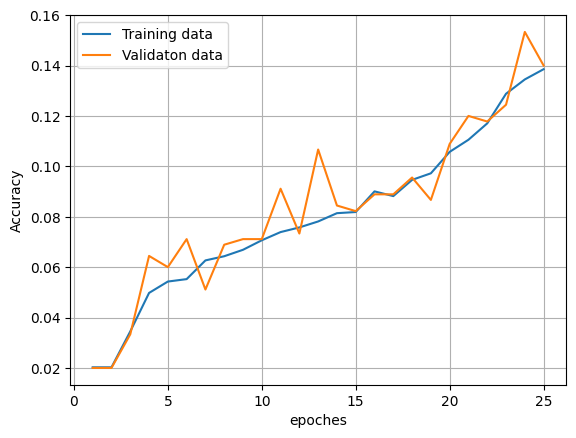

In [ ]:
x = np.arange(1, epoches + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, acc_list[0])
plt.plot(x, acc_list[1])
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW2/LeNet5_model/LeNet5_accuracy.png")
plt.show()

**Save accuracy result (can skip)**

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/DL/HW2/LeNet5_model/acc_list.npz", train_acc=acc_list[0], valid_acc=acc_list[1])

## Part 7 : Result

**Load train and valid accuracy**

In [ ]:
with np.load("/content/drive/MyDrive/DL/HW2/LeNet5_model/acc_list.npz") as data:
    acc_train = data["train_acc"]
    acc_valid = data["valid_acc"]

In [ ]:
def answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW2/LeNet5_model/' + output_name + '_test_result.csv')
  return test_result

**Test**

In [ ]:
LeNet5_test_acc, LeNet5_y_pred = test("/content/drive/MyDrive/DL/HW2/LeNet5_model/lenet5_data_" + str(acc_valid.argmax() + 1) + ".pkl", test_data)

Testing with /content/drive/MyDrive/DL/HW2/LeNet5_model/lenet5_data_24.pkl:
Accuracy of test set: 0.14444444444444443


In [ ]:
# Test accuracy
LeNet5_test_acc = round(LeNet5_test_acc,4)
LeNet5_test_acc

0.1444

In [ ]:
output_name = 'LeNet5'
LeNet5_answer = answer(test_y, LeNet5_y_pred, test_dir, output_name)
LeNet5_answer

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,48
images/n02111277/n02111277_9422.JPEG,0,32
images/n02111277/n02111277_9484.JPEG,0,41
images/n02111277/n02111277_951.JPEG,0,41
images/n02111277/n02111277_9518.JPEG,0,46
...,...,...
images/n02172182/n02172182_974.JPEG,49,44
images/n02172182/n02172182_9765.JPEG,49,34
images/n02172182/n02172182_9789.JPEG,49,49
images/n02172182/n02172182_98.JPEG,49,41


# Improved LeNet-5 

**Please follow the operations to modify naive LeNet.**

*   Activation function: x = Sigmoid(x) ==> x = x*sigmoid(x)
*   Kernel size: 5x5 ==> 3x3
*   Increase one convolution layer to LeNet5 (any position)




## Part 1 : CNN Layer

### Improved Sigmoid Activation Layer

Activation function: x = Sigmoid(x) ==> x = x*sigmoid(x)

In [ ]:
class X_Sigmoid_Layer:
    def forward_propagation(self, input_map):
        self.input_map = input_map
        self.sigmoid = 1 / (1 + np.exp(-input_map))
        self.output_map = input_map * self.sigmoid
        return self.output_map

    def back_propagation(self, d_output_map):
        dsigmoid = self.sigmoid * (1 - self.sigmoid)
        d_input_map = np.multiply(d_output_map, (self.sigmoid + np.multiply(self.input_map, dsigmoid)))
        self.output_map = None
        return d_input_map

## Part 2 : Inproved LeNet-5

Kernel size: 5x5 ==> 3x3

Increase one convolution layer to LeNet5 (any position)

In [ ]:
class Imp_LeNet5:
    def __init__(self):

        kernel_shape = {"C1": (3, 3, 3, 6),
                        "C3": (3, 3, 6, 16),
                        "C5": (3, 3, 16, 120),
                        "C6": (3, 3, 120, 120),
                        "F7": (120, 84),
                        "F8": (84, 50)}

        self.C1 = Conv_Layer(kernel_shape["C1"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid1 = X_Sigmoid_Layer()
        self.S2 = MaxPool_Layer()
        self.C3 = Conv_Layer(kernel_shape["C3"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid2 = X_Sigmoid_Layer()
        self.S4 = MaxPool_Layer()
        self.C5 = Conv_Layer(kernel_shape["C5"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid3 = X_Sigmoid_Layer()
        self.C6 = Conv_Layer(kernel_shape["C6"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid4 = X_Sigmoid_Layer()
        self.F7 = FC_Layer(kernel_shape["F7"], sigma = 0.1, bias_factor = 0.01)
        self.Sigmoid5 = X_Sigmoid_Layer()
        self.F8 = FC_Output_Layer(kernel_shape["F8"], sigma = 0.1, bias_factor = 0.01)

    def forward_propagation(self, input_image, input_label, mode):
        C1_FP = self.C1.forward_propagation(input_image)
        Sigmoid1_FP = self.Sigmoid1.forward_propagation(C1_FP)
        S2_FP = self.S2.forward_propagation(Sigmoid1_FP)
        C3_FP = self.C3.forward_propagation(S2_FP)
        Sigmoid2_FP = self.Sigmoid2.forward_propagation(C3_FP)
        S4_FP = self.S4.forward_propagation(Sigmoid2_FP)
        C5_FP = self.C5.forward_propagation(S4_FP)
        Sigmoid3_FP = self.Sigmoid3.forward_propagation(C5_FP)
        C6_FP = self.C6.forward_propagation(Sigmoid3_FP)
        Sigmoid4_FP = self.Sigmoid4.forward_propagation(C6_FP)
        Sigmoid4_FP = Sigmoid4_FP[:, 0, 0, :]
        F7_FP = self.F7.forward_propagation(Sigmoid4_FP)
        Sigmoid5_FP = self.Sigmoid5.forward_propagation(F7_FP)
        return self.F8.forward_propagation(Sigmoid5_FP, input_label, mode)

    def back_propagation(self, learning_rate):
        F8_BP = self.F8.back_propagation(learning_rate)
        Sigmoid5_BP = self.Sigmoid5.back_propagation(F8_BP)
        F7_BP = self.F7.back_propagation(Sigmoid5_BP, learning_rate)
        F7_BP = F7_BP[:, np.newaxis, np.newaxis, :]
        Sigmoid4_BP = self.Sigmoid4.back_propagation(F7_BP)
        C6_BP = self.C6.back_propagation(Sigmoid4_BP, learning_rate)
        Sigmoid3_BP = self.Sigmoid3.back_propagation(C6_BP)
        C5_BP = self.C5.back_propagation(Sigmoid3_BP, learning_rate)
        S4_BP = self.S4.back_propagation(C5_BP)
        Sigmoid2_BP = self.Sigmoid2.back_propagation(S4_BP)
        C3_BP = self.C3.back_propagation(Sigmoid2_BP, learning_rate)
        S2_BP = self.S2.back_propagation(C3_BP)
        Sigmoid1_BP = self.Sigmoid1.back_propagation(S2_BP)
        self.C1.back_propagation(Sigmoid1_BP, learning_rate)
    
    def extract_model(self):
        temp_model = Imp_LeNet5()
        temp_model.C1.weight = self.C1.weight
        temp_model.C1.bias = self.C1.bias
        temp_model.C1.stride = self.C1.stride
        temp_model.C1.pad = self.C1.pad
        temp_model.S2.stride = self.S2.stride
        temp_model.S2.f = self.S2.f
        temp_model.C3.weight = self.C3.weight
        temp_model.C3.bias = self.C3.bias
        temp_model.C3.stride = self.C3.stride
        temp_model.C3.pad = self.C3.pad
        temp_model.S4.stride = self.S4.stride
        temp_model.S4.f = self.S4.f
        temp_model.C5.weight = self.C5.weight
        temp_model.C5.bias = self.C5.bias
        temp_model.C5.stride = self.C5.stride
        temp_model.C5.pad = self.C5.pad
        temp_model.C6.weight = self.C6.weight
        temp_model.C6.bias = self.C6.bias
        temp_model.C6.stride = self.C6.stride
        temp_model.C6.pad = self.C6.pad

        temp_model.F7.weight = self.F7.weight
        temp_model.F7.bias = self.F7.bias
        temp_model.F8.weight = self.F8.weight
        temp_model.F8.bias = self.F8.bias
        return temp_model

## Part 3 : Train

In [ ]:
def improved_train(model, train_data, valid_data, epoches, learning_rate_list, batch_size):
    # training loops
    start_time = time.time()
    acc_rate_list = []

    for epoch in range(0, epoches):
        print("---------- epoch", epoch + 1, "begin ----------")
        learning_rate = learning_rate_list[epoch]
        # print information
        print("learning rate: {}".format(learning_rate))
        print("batch size: {}".format(batch_size))
        # loop over each batch
        start_time_epoch = time.time()
        cost = 0
        mini_batches = random_mini_batches(train_data[0], train_data[1], batch_size)
        print("Training:")
        for i in tqdm(range(len(mini_batches))):
            batch_image, batch_label = mini_batches[i]
            loss = model.forward_propagation(batch_image, batch_label, "train")
            cost += loss
            model.back_propagation(learning_rate)
        print("Done, total cost of epoch {}: {}".format(epoch + 1, cost))
        
        acc_train = model.forward_propagation(train_data[0][0:30000], train_data[1][0:30000], "test")[0]
        acc_train += model.forward_propagation(train_data[0][30000:len(valid_data[1])], train_data[1][30000:len(valid_data[1])], "test")[0]
        
        acc_valid, _ = model.forward_propagation(valid_data[0], valid_data[1], "test")


        acc_rate_list.append([acc_train / len(train_data[1]), acc_valid / len(valid_data[1])])
        print("0/1 Accuracy of training set:", acc_train, "/", len(train_data[1]))
        print("0/1 Accuracy of valid set:", acc_valid, "/", len(valid_data[1]))
        print("Time used:", time.time() - start_time_epoch, "sec")
        print("---------- epoch", epoch + 1, "end ------------")
        with open("/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/improved_lenet5_data_" + str(epoch + 1) + ".pkl", "wb") as output:
            pickle.dump(model.extract_model(), output, pickle.HIGHEST_PROTOCOL)
    acc_rate_list = np.array(acc_rate_list).T
    print("Total time used:", time.time() - start_time, "sec")
  
    return acc_rate_list

## Part 4 : Train Model and Draw Performance

In [ ]:
train_data = load_dataset(X_train, train_y)
valid_data = load_dataset(X_valid, valid_y)
test_data = load_dataset(X_test, test_y)

In [ ]:
batch_size = 64
epoches = 25
learning_rate_list = np.array([1e-1] * 5 + [5e-2] * 5 + [1e-2] * 10 + [5e-3] *5 )
model2 = Imp_LeNet5()

In [ ]:
# Training
acc_list_improved = improved_train(model2, train_data, valid_data, epoches, learning_rate_list, batch_size)

---------- epoch 1 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [08:47<00:00,  1.88it/s]


Done, total cost of epoch 1: 221414.27278553843
0/1 Accuracy of training set: 1878 / 63325
0/1 Accuracy of valid set: 49 / 450
Time used: 565.345187664032 sec
---------- epoch 1 end ------------
---------- epoch 2 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [09:13<00:00,  1.79it/s]


Done, total cost of epoch 2: 202945.29389176646
0/1 Accuracy of training set: 4062 / 63325
0/1 Accuracy of valid set: 65 / 450
Time used: 584.8558320999146 sec
---------- epoch 2 end ------------
---------- epoch 3 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [09:14<00:00,  1.79it/s]


Done, total cost of epoch 3: 199933.21980010474
0/1 Accuracy of training set: 4075 / 63325
0/1 Accuracy of valid set: 72 / 450
Time used: 584.4040994644165 sec
---------- epoch 3 end ------------
---------- epoch 4 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [07:22<00:00,  2.24it/s]


Done, total cost of epoch 4: 198600.93462157724
0/1 Accuracy of training set: 3144 / 63325
0/1 Accuracy of valid set: 60 / 450
Time used: 477.79440689086914 sec
---------- epoch 4 end ------------
---------- epoch 5 begin ----------
learning rate: 0.1
batch size: 64
Training:


100%|██████████| 990/990 [05:50<00:00,  2.83it/s]


Done, total cost of epoch 5: 198682.17555621848
0/1 Accuracy of training set: 3653 / 63325
0/1 Accuracy of valid set: 59 / 450
Time used: 381.527188539505 sec
---------- epoch 5 end ------------
---------- epoch 6 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [05:52<00:00,  2.81it/s]


Done, total cost of epoch 6: 190063.6993484853
0/1 Accuracy of training set: 4286 / 63325
0/1 Accuracy of valid set: 62 / 450
Time used: 383.9799726009369 sec
---------- epoch 6 end ------------
---------- epoch 7 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [05:49<00:00,  2.84it/s]


Done, total cost of epoch 7: 190040.2427678504
0/1 Accuracy of training set: 4178 / 63325
0/1 Accuracy of valid set: 73 / 450
Time used: 378.6408054828644 sec
---------- epoch 7 end ------------
---------- epoch 8 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [05:56<00:00,  2.78it/s]


Done, total cost of epoch 8: 190683.23158517558
0/1 Accuracy of training set: 3695 / 63325
0/1 Accuracy of valid set: 76 / 450
Time used: 387.33667612075806 sec
---------- epoch 8 end ------------
---------- epoch 9 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [05:49<00:00,  2.83it/s]


Done, total cost of epoch 9: 191818.54244191505
0/1 Accuracy of training set: 4090 / 63325
0/1 Accuracy of valid set: 71 / 450
Time used: 379.5221064090729 sec
---------- epoch 9 end ------------
---------- epoch 10 begin ----------
learning rate: 0.05
batch size: 64
Training:


100%|██████████| 990/990 [05:56<00:00,  2.78it/s]


Done, total cost of epoch 10: 193140.1721968782
0/1 Accuracy of training set: 3834 / 63325
0/1 Accuracy of valid set: 76 / 450
Time used: 388.496577501297 sec
---------- epoch 10 end ------------
---------- epoch 11 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [05:49<00:00,  2.83it/s]


Done, total cost of epoch 11: 178294.8877236947
0/1 Accuracy of training set: 5059 / 63325
0/1 Accuracy of valid set: 81 / 450
Time used: 380.09495759010315 sec
---------- epoch 11 end ------------
---------- epoch 12 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [05:50<00:00,  2.82it/s]


Done, total cost of epoch 12: 176692.12950919117
0/1 Accuracy of training set: 5554 / 63325
0/1 Accuracy of valid set: 81 / 450
Time used: 381.5777094364166 sec
---------- epoch 12 end ------------
---------- epoch 13 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:04<00:00,  2.72it/s]


Done, total cost of epoch 13: 176567.87252877833
0/1 Accuracy of training set: 5308 / 63325
0/1 Accuracy of valid set: 81 / 450
Time used: 393.7834823131561 sec
---------- epoch 13 end ------------
---------- epoch 14 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [05:58<00:00,  2.76it/s]


Done, total cost of epoch 14: 176592.03506631785
0/1 Accuracy of training set: 4838 / 63325
0/1 Accuracy of valid set: 79 / 450
Time used: 402.64575457572937 sec
---------- epoch 14 end ------------
---------- epoch 15 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Done, total cost of epoch 15: 176558.35383548806
0/1 Accuracy of training set: 5125 / 63325
0/1 Accuracy of valid set: 69 / 450
Time used: 415.4086391925812 sec
---------- epoch 15 end ------------
---------- epoch 16 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:03<00:00,  2.72it/s]


Done, total cost of epoch 16: 177163.30418270244
0/1 Accuracy of training set: 4989 / 63325
0/1 Accuracy of valid set: 72 / 450
Time used: 409.92899560928345 sec
---------- epoch 16 end ------------
---------- epoch 17 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:09<00:00,  2.68it/s]


Done, total cost of epoch 17: 177292.46169199544
0/1 Accuracy of training set: 4645 / 63325
0/1 Accuracy of valid set: 76 / 450
Time used: 415.60876727104187 sec
---------- epoch 17 end ------------
---------- epoch 18 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:06<00:00,  2.70it/s]


Done, total cost of epoch 18: 177468.4098981854
0/1 Accuracy of training set: 4710 / 63325
0/1 Accuracy of valid set: 69 / 450
Time used: 410.8172948360443 sec
---------- epoch 18 end ------------
---------- epoch 19 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [06:13<00:00,  2.65it/s]


Done, total cost of epoch 19: 177547.45024262014
0/1 Accuracy of training set: 5148 / 63325
0/1 Accuracy of valid set: 74 / 450
Time used: 421.3515717983246 sec
---------- epoch 19 end ------------
---------- epoch 20 begin ----------
learning rate: 0.01
batch size: 64
Training:


100%|██████████| 990/990 [05:59<00:00,  2.75it/s]


Done, total cost of epoch 20: 178426.01206597194
0/1 Accuracy of training set: 4798 / 63325
0/1 Accuracy of valid set: 69 / 450
Time used: 389.453444480896 sec
---------- epoch 20 end ------------
---------- epoch 21 begin ----------
learning rate: 0.005
batch size: 64
Training:


100%|██████████| 990/990 [05:49<00:00,  2.83it/s]


Done, total cost of epoch 21: 171386.05660375912
0/1 Accuracy of training set: 5700 / 63325
0/1 Accuracy of valid set: 84 / 450
Time used: 381.0797369480133 sec
---------- epoch 21 end ------------
---------- epoch 22 begin ----------
learning rate: 0.005
batch size: 64
Training:


100%|██████████| 990/990 [05:49<00:00,  2.83it/s]


Done, total cost of epoch 22: 171315.68021729978
0/1 Accuracy of training set: 5748 / 63325
0/1 Accuracy of valid set: 85 / 450
Time used: 384.3857867717743 sec
---------- epoch 22 end ------------
---------- epoch 23 begin ----------
learning rate: 0.005
batch size: 64
Training:


100%|██████████| 990/990 [05:50<00:00,  2.82it/s]


Done, total cost of epoch 23: 171535.04599892566
0/1 Accuracy of training set: 5680 / 63325
0/1 Accuracy of valid set: 68 / 450
Time used: 381.60327672958374 sec
---------- epoch 23 end ------------
---------- epoch 24 begin ----------
learning rate: 0.005
batch size: 64
Training:


100%|██████████| 990/990 [05:50<00:00,  2.82it/s]


Done, total cost of epoch 24: 171741.58898351435
0/1 Accuracy of training set: 5097 / 63325
0/1 Accuracy of valid set: 77 / 450
Time used: 380.0788598060608 sec
---------- epoch 24 end ------------
---------- epoch 25 begin ----------
learning rate: 0.005
batch size: 64
Training:


100%|██████████| 990/990 [05:51<00:00,  2.81it/s]


Done, total cost of epoch 25: 171581.6414897929
0/1 Accuracy of training set: 5855 / 63325
0/1 Accuracy of valid set: 93 / 450
Time used: 381.83200335502625 sec
---------- epoch 25 end ------------
Total time used: 10442.276111125946 sec


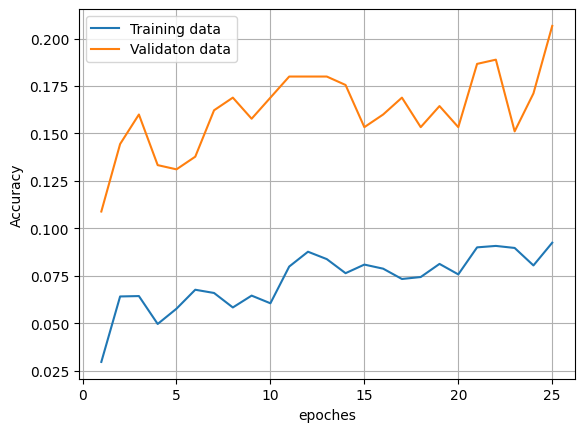

In [ ]:
x = np.arange(1, epoches + 1)
plt.xlabel("epoches")
plt.ylabel("Accuracy")
plt.plot(x, acc_list_improved[0])
plt.plot(x, acc_list_improved[1])
plt.grid(True)
plt.legend(["Training data", "Validaton data"], loc = "upper left")
plt.savefig("/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/Improved_LeNet5_accuracy.png")
plt.show()

**Save accuracy result (can skip)**

In [ ]:
# save them to a file
np.savez("/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/improved_acc_list.npz", train_acc=acc_list_improved[0], valid_acc=acc_list_improved[1])

## Part 5 : Result

**Load train and valid accuracy**

In [ ]:
with np.load("/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/improved_acc_list.npz") as data:
    improved_acc_train = data["train_acc"]
    improved_acc_valid = data["valid_acc"]

In [ ]:
def improved_answer(test_y, test_y_pred, data_name, output_name):
  df = np.column_stack((test_y, test_y_pred))
  test_result = pd.DataFrame(df, index=data_name, columns=['Answer','Prediction'])
  test_result.to_csv('/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/' + output_name + '_improved_test_result.csv')
  return test_result

**Test**

In [ ]:
Imp_LeNet5_test_acc, Imp_LeNet5_y_pred = test("/content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/improved_lenet5_data_" + str(improved_acc_valid.argmax() + 1) + ".pkl", test_data)

Testing with /content/drive/MyDrive/DL/HW2/Improved_LeNet5_model/improved_lenet5_data_25.pkl:
Accuracy of test set: 0.2088888888888889


In [ ]:
# Test accuracy
Imp_LeNet5_test_acc = round(Imp_LeNet5_test_acc,4)
Imp_LeNet5_test_acc

0.2089

In [ ]:
output_name = 'Improved_LeNet5'
Imp_LeNet5_answer = improved_answer(test_y, Imp_LeNet5_y_pred, test_dir, output_name)
Imp_LeNet5_answer

,Answer,Prediction
images/n02111277/n02111277_9420.JPEG,0,38
images/n02111277/n02111277_9422.JPEG,0,1
images/n02111277/n02111277_9484.JPEG,0,5
images/n02111277/n02111277_951.JPEG,0,0
images/n02111277/n02111277_9518.JPEG,0,46
...,...,...
images/n02172182/n02172182_974.JPEG,49,49
images/n02172182/n02172182_9765.JPEG,49,19
images/n02172182/n02172182_9789.JPEG,49,49
images/n02172182/n02172182_98.JPEG,49,46


# Performance

In [ ]:
perform_df_LeNet5 = pd.DataFrame([
    [3, '5*5', 'Sigmoid(x)', '0.1, 0.05', 25, 64, LeNet5_test_acc],
    [4, '3*3', 'x*sigmoid(x)', '0.1, 0.05, 0.01, 0.005', 25, 64, Imp_LeNet5_test_acc]],
    columns=['Conv_layers', 'Kernel size', 'Activation function', 'lr', 'n_epochs', 'batch_size', 'top1 acc'],
    index=['Naive LeNet5', 'Improved LeNet5'])

In [ ]:
perform_df_LeNet5

,Conv_layers,Kernel size,Activation function,lr,n_epochs,batch_size,top1 acc
Naive LeNet5,3,5*5,Sigmoid(x),"0.1, 0.05",25,64,0.1444
Improved LeNet5,4,5*5,x*sigmoid(x),"0.1, 0.05, 0.01, 0.005",25,64,0.2089
